In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Dataset loaded:
X shape: (4049, 80, 80, 3)
y shape: (4049,)
Train set: (3239, 80, 80, 3) (3239, 5)
Validation set: (810, 80, 80, 3) (810, 5)


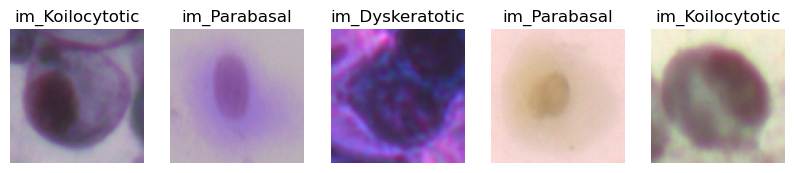

In [2]:
# Path to your dataset in Kaggle
DATASET_PATH = r"C:\Users\User\Downloads\cervical-cancer-largest-dataset-sipakmed"

# Define class folders
classes = [
    "im_Dyskeratotic",
    "im_Koilocytotic",
    "im_Metaplastic",
    "im_Parabasal",
    "im_Superficial-Intermediate"
]

# Parameters
IMG_SIZE = 80  # resize all images to 80x80 (as in SIPaKMeD paper)
X = []
y = []

# Loop through classes and load images
for idx, cls in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, cls, cls, "CROPPED")  # goes inside CROPPED folder
    for file in os.listdir(class_path):
        if file.endswith(".bmp"):
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(idx)

# Convert to numpy arrays
X = np.array(X, dtype="float32") / 255.0  # normalize [0,1]
y = np.array(y)

print("Dataset loaded:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# One-hot encode labels
y = to_categorical(y, num_classes=len(classes))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

# Show sample images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i])
    plt.title(classes[np.argmax(y_train[i])])
    plt.axis("off")
plt.show()

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,191,941 (8.36 MB)

 Trainable params: 2,191,941 (8.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7240 - loss: 0.7677 - val_accuracy: 0.7160 - val_loss: 0.6999
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7483 - loss: 0.6726 - val_accuracy: 0.7926 - val_loss: 0.5790
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7716 - loss: 0.6123 - val_accuracy: 0.7802 - val_loss: 0.5958
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7878 - loss: 0.5992 - val_accuracy: 0.8272 - val_loss: 0.4544
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8223 - loss: 0.4980 - val_accuracy: 0.8235 - val_loss: 0.4585
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.8270 - loss: 0.4794 - val_accuracy: 0.8765 - val_loss: 0.3123
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.8259 - loss: 0.4767 - val_accuracy: 0.8691 - val_loss: 0.3801
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.8388 - loss: 0.4309 - val_accu

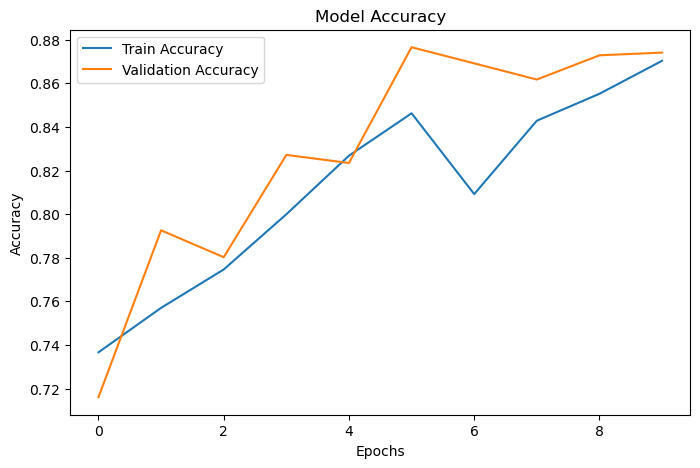

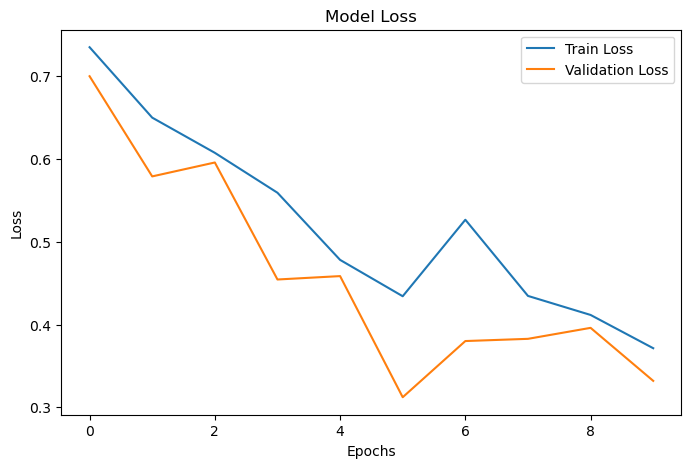

In [6]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


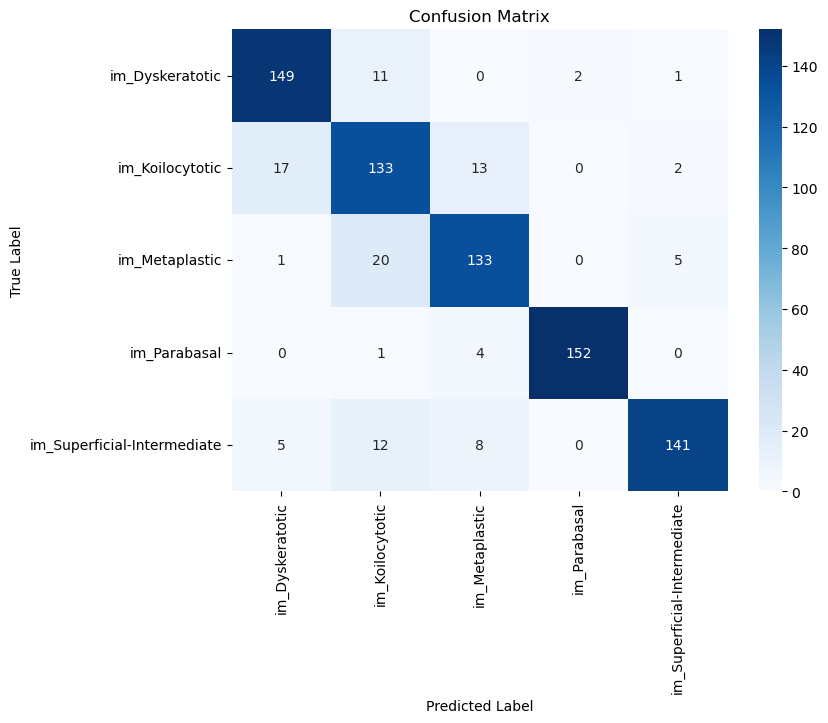

Classification Report:

                             precision    recall  f1-score   support

            im_Dyskeratotic       0.87      0.91      0.89       163
            im_Koilocytotic       0.75      0.81      0.78       165
             im_Metaplastic       0.84      0.84      0.84       159
               im_Parabasal       0.99      0.97      0.98       157
im_Superficial-Intermediate       0.95      0.85      0.90       166

                   accuracy                           0.87       810
                  macro avg       0.88      0.87      0.88       810
               weighted avg       0.88      0.87      0.88       810



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=classes))

Overall Macro AUC: 0.9828


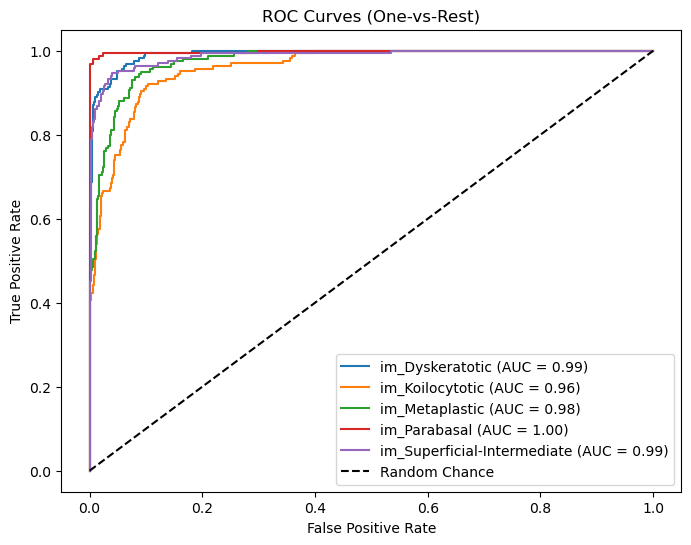

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# For multi-class ROC-AUC
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))
y_pred_prob = y_pred  # already softmax probabilities from model.predict()

# Compute macro-average AUC
auc_score = roc_auc_score(y_true_bin, y_pred_prob, average="macro")
print(f"Overall Macro AUC: {auc_score:.4f}")

# Plot ROC curves for each class
plt.figure(figsize=(8,6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0,1], [0,1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


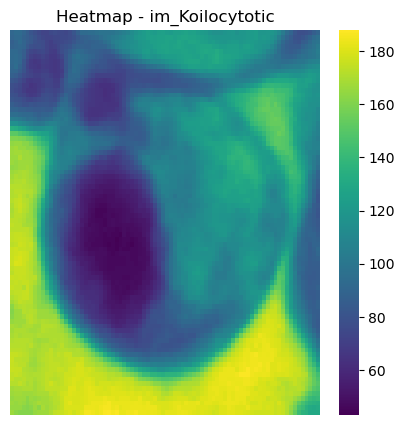

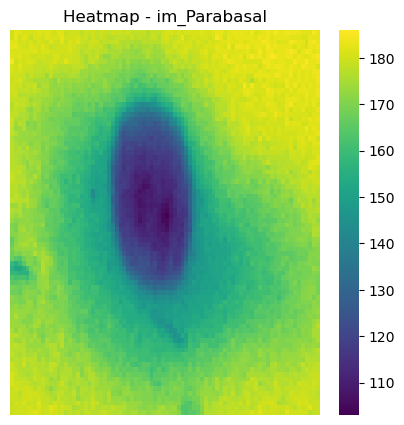

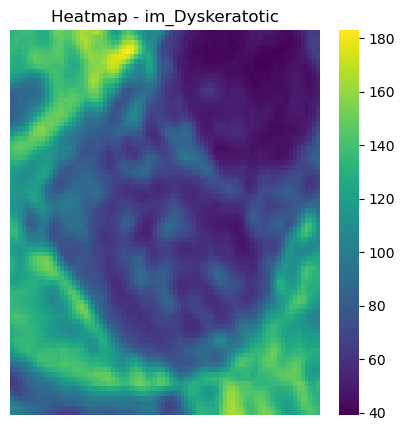

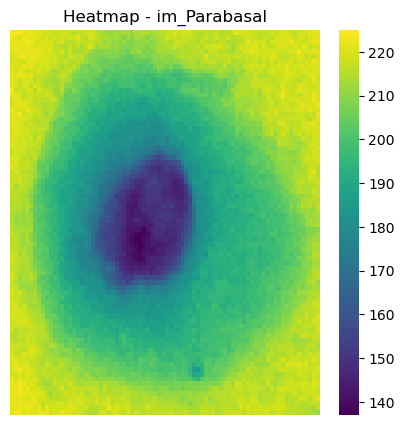

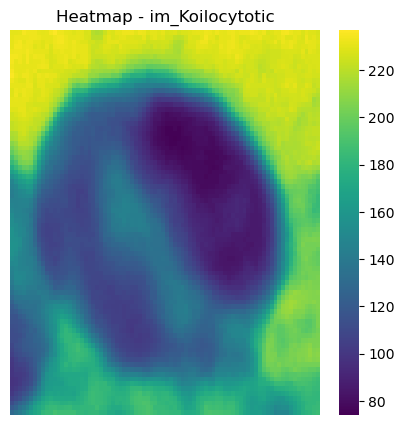

In [9]:
#HEATMAP
import seaborn as sns

# Function to plot heatmap of an image (grayscale intensity)
def plot_image_heatmap(image, title="Heatmap"):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(5,5))
    sns.heatmap(gray, cmap="viridis")  # you can change cmap to 'magma', 'coolwarm', etc.
    plt.title(title)
    plt.axis("off")
    plt.show()

# Plot heatmaps for a few sample images
for i in range(5):
    img = (X_train[i] * 255).astype(np.uint8)
    label = classes[np.argmax(y_train[i])]
    plot_image_heatmap(img, title=f"Heatmap - {label}")

=== Total Images per Class ===
im_Dyskeratotic          : 813
im_Koilocytotic          : 825
im_Metaplastic           : 793
im_Parabasal             : 787
im_Superficial-Intermediate: 831

Total images in dataset: 4049


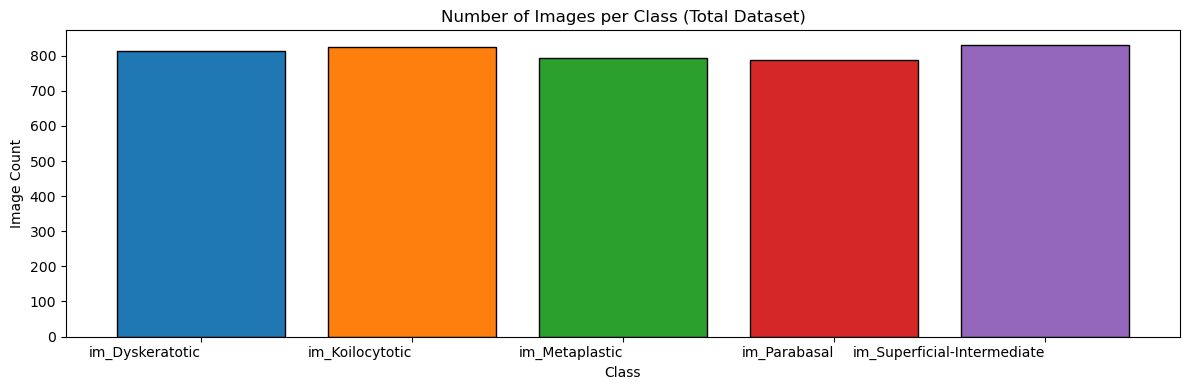

In [10]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Count total images per class (integer labels from one-hot)
y_total_int = np.argmax(y, axis=1)
total_counts = Counter(y_total_int)

# === Print total images per class ===
print("=== Total Images per Class ===")
for idx, cls in enumerate(classes):
    print(f"{cls:25s}: {total_counts[idx]}")
print(f"\nTotal images in dataset: {sum(total_counts.values())}")

# === Bar chart with Matplotlib colormap ===
# 'tab10' is a Matplotlib colormap designed for up to 10 distinct categories
num_classes = len(classes)
cmap = plt.get_cmap('tab10')  # get the colormap object
bar_colors = [cmap(i) for i in range(num_classes)]

plt.figure(figsize=(12,4))
plt.bar(classes,
        [total_counts[i] for i in range(num_classes)],
        color=bar_colors,      # each bar gets a unique color
        edgecolor="black")

plt.title("Number of Images per Class (Total Dataset)")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()